In [1]:
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from torch_geometric.nn import GCNConv
import networkx as nx
from sklearn.model_selection import train_test_split
from scipy.sparse import csgraph
from scipy.spatial.distance import cdist
import numpy as np
from sklearn.neighbors import kneighbors_graph

from torch_geometric.data import Data, DataLoader
import matplotlib.pyplot as plt

c:\Users\marti\anaconda3\lib\site-packages\torch_geometric\typing.py:42: UserWarning: An issue occurred while importing 'torch-sparse'. Disabling its usage. Stacktrace: [WinError 127] The specified procedure could not be found
  warnings.warn(f"An issue occurred while importing 'torch-sparse'. "


Get data

In [2]:
# Load the data from the CSV file
data = pd.read_csv('data\\data.csv',skip_blank_lines=False)

# Preprocess the data
locations = []
targets = []
current_locations = []
current_target = []
for _, row in data.iterrows():
    if row.isnull().all():
        if current_locations:
            locations.append(current_locations)
            current_locations = []
        if current_target:
            targets.append(current_target)
            current_target = []
    else:
        current_target.append(row['v'].tolist())
        current_locations.append(row[['x1','x2']].tolist())

# Convert the data into tensors
input_features = [torch.tensor(instance, dtype=torch.float) for instance in locations]
targets = [torch.tensor(instance, dtype=torch.long) for instance in targets]
print(len(input_features), len(targets))

916 916


C:\Users\marti\AppData\Local\Temp\ipykernel_7668\3801889071.py:23: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  targets = [torch.tensor(instance, dtype=torch.long) for instance in targets]


In [3]:
# Generate edge_index tensor using k-nearest neighbors
edge_indices = []
k = 30 # Number of nearest neighbors

for i,instance in enumerate(locations):
    instance_tensor = torch.tensor(instance, dtype=torch.float)
    adjacency_matrix = kneighbors_graph(instance_tensor, k, mode='connectivity', include_self=False).tocoo()
    edge_index = torch.tensor(adjacency_matrix.nonzero(), dtype=torch.long)
    edge_indices.append(edge_index)
    # Calculate sparsity of the graph
    num_nodes = instance_tensor.shape[0]
    num_edges = adjacency_matrix.nnz
    sparsity = num_edges / (num_nodes * num_nodes)
    # print(f"Instance {i + 1} sparsity: {sparsity:.4f}")

# Split data into training and testing sets
input_train, input_test, target_train, target_test, edge_train, edge_test = train_test_split(
    input_features, targets, edge_indices, test_size=0.7, random_state=42
)

C:\Users\marti\AppData\Local\Temp\ipykernel_7668\1904675315.py:8: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\torch\csrc\utils\tensor_new.cpp:248.)
  edge_index = torch.tensor(adjacency_matrix.nonzero(), dtype=torch.long)


Instance 0 sparsity: 0.6122


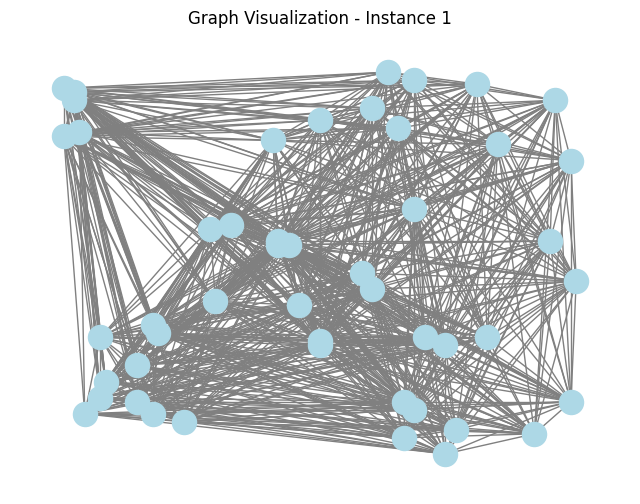

In [4]:
# visualize one of the graphs
# Select an instance to visualize
instance_index = 0
instance = locations[instance_index]
instance_tensor = torch.tensor(instance, dtype=torch.float)
edge_index = kneighbors_graph(instance_tensor, n_neighbors=k, mode='connectivity', include_self=False).tocoo()
num_nodes = instance_tensor.shape[0]
num_edges = edge_index.nnz
sparsity = num_edges / (num_nodes * num_nodes)
print(f"Instance {instance_index} sparsity: {sparsity:.4f}")
# Create a NetworkX graph
graph = nx.Graph()
graph.add_edges_from(zip(edge_index.row, edge_index.col))

# Plot the graph
plt.figure(figsize=(8, 6))
nx.draw_networkx(graph, pos={i: loc for i, loc in enumerate(instance)}, node_color='lightblue', edge_color='gray', with_labels=False)
plt.title(f"Graph Visualization - Instance {instance_index+1}")
plt.axis('off')
plt.show()

In [90]:
import torch.nn.functional as F

class GNN(nn.Module):
    def __init__(self, input_dim, hidden_dim):
        super(GNN, self).__init__()
        self.convs = nn.ModuleList()
        for i in range(len(hidden_dim)):
            if i == 0:
                self.convs.append(GCNConv(input_dim, hidden_dim[i]))
            else:
                self.convs.append(GCNConv(hidden_dim[i-1], hidden_dim[i]))

    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        for conv in self.convs:
            x = conv(x, edge_index)
            x = torch.relu(x)
        return x
    
class CommunityLoss(nn.Module):
    def __init__(self, temperature=0.1):
        super(CommunityLoss, self).__init__()
        self.temperature = temperature

    def forward(self, embeddings, batch):
        # Normalize embeddings
        embeddings = F.normalize(embeddings, dim=1)

        # Split embeddings into anchor and positive samples
        anchor = []
        positive = []
        for i in range(batch.num_graphs):
            start_idx = batch.ptr[i]
            end_idx = batch.ptr[i + 1]
            graph_embeddings = embeddings[start_idx:end_idx]

            # Get positive indices based on community labels
            labels = batch.y[start_idx:end_idx]
            unique_labels = torch.unique(labels)
            for label in unique_labels:
                indices = (labels == label).nonzero().squeeze()
                selected_idx = torch.randint(low=0, high=indices.numel(), size=(1,)).item()
                print(selected_idx)
                anchor.append(graph_embeddings[0])
                positive.append(graph_embeddings[indices[selected_idx]])

        anchor = torch.stack(anchor)
        positive = torch.stack(positive)

        # Calculate cosine similarity between each anchor and positive pair
        similarity = torch.cosine_similarity(anchor, positive, dim=1) / self.temperature

        # Construct target labels (1 for positive samples, 0 for negative samples)
        target = torch.ones_like(similarity)

        # Calculate the contrastive loss
        loss = F.binary_cross_entropy_with_logits(similarity, target)
        return loss

In [63]:
def train_epoch(model, data_loader, optimizer, criterion):
    model.train()
    epoch_loss = 0

    for data in data_loader:
        optimizer.zero_grad()
        embeddings = model(data)
        loss = criterion(embeddings, data)

        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()

    return epoch_loss / len(data_loader)

def evaluate(model, test_loader):
    model.eval()
    correct = 0
    total = 0

    with torch.no_grad():
        for data in test_loader:
            output = model(data)
            _, predicted = torch.max(output, dim=1)
            correct += (predicted == data.y).sum().item()
            total += data.y.size(0)

    accuracy = correct / total
    return accuracy

In [89]:
input_dim = 2  # Dimensionality of input features (location coordinates)
hidden_dim = [8]  # Dimensionality of hidden layers

batch_size = 64

model = GNN(input_dim, hidden_dim)

# Train the GNN model
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)
optimizer = optim.Adam(model.parameters(), lr=0.01)
criterion = CommunityLoss()

anchor_indices = []
num_anchors = 10  # Number of anchor nodes per graph instance

for instance in locations:
    num_nodes = len(instance)
    indices = np.random.choice(num_nodes, size=num_anchors, replace=False)
    anchor_indices.append(indices)

train_data = [
    Data(x=feature, y=target, edge_index=edge, anchor=anchor)
    for feature, target, edge, anchor in zip(
        input_train, target_train, edge_train, anchor_indices
    )
]
train_loader = DataLoader(train_data, batch_size=batch_size)
test_data = [Data(x=feature, y=target, edge_index=edge) for feature, target, edge in zip(input_test, target_test, edge_test)]
test_loader = DataLoader(test_data, batch_size=batch_size)

train_losses = []
test_accs = []

num_epochs = 200
for epoch in range(num_epochs):
    train_loss = train_epoch(model, train_loader, optimizer, criterion)
    test_acc = evaluate(model, test_loader)

    train_losses.append(train_loss)
    test_accs.append(test_acc)
    
    # if (epoch + 1) % 10 == 0:
    #     print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss:.4f}, Test acc: {test_acc:.4f}")

tensor(0.0256, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
tensor(0.0120, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
tensor(0.0067, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
tensor(0.0042, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)


IndexError: invalid index of a 0-dim tensor. Use `tensor.item()` in Python or `tensor.item<T>()` in C++ to convert a 0-dim tensor to a number

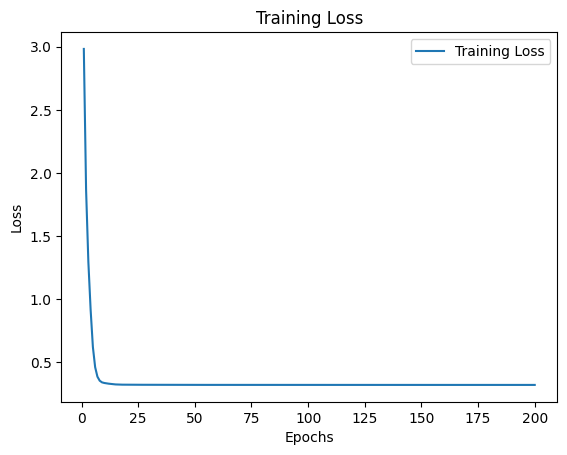

In [ ]:
# Plotting the training loss
plt.plot(range(1, num_epochs + 1), train_losses, label='Training Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training Loss')
plt.legend()
plt.show()

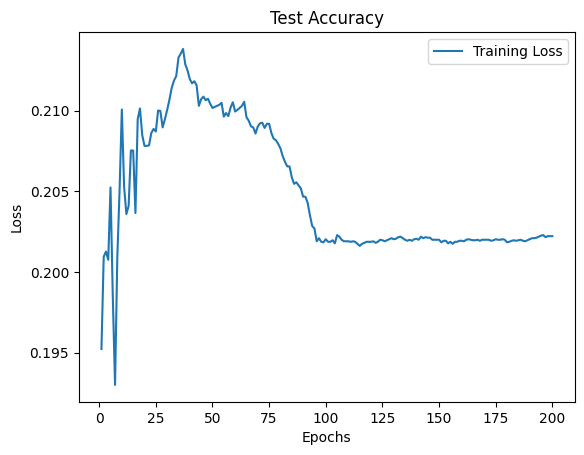

In [ ]:
# Plotting the test accuracy
plt.plot(range(1, num_epochs + 1), test_accs, label='Training Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Test Accuracy')
plt.legend()
plt.show()

check model performance

Data(x=[49, 2], edge_index=[2, 1470], y=[49])


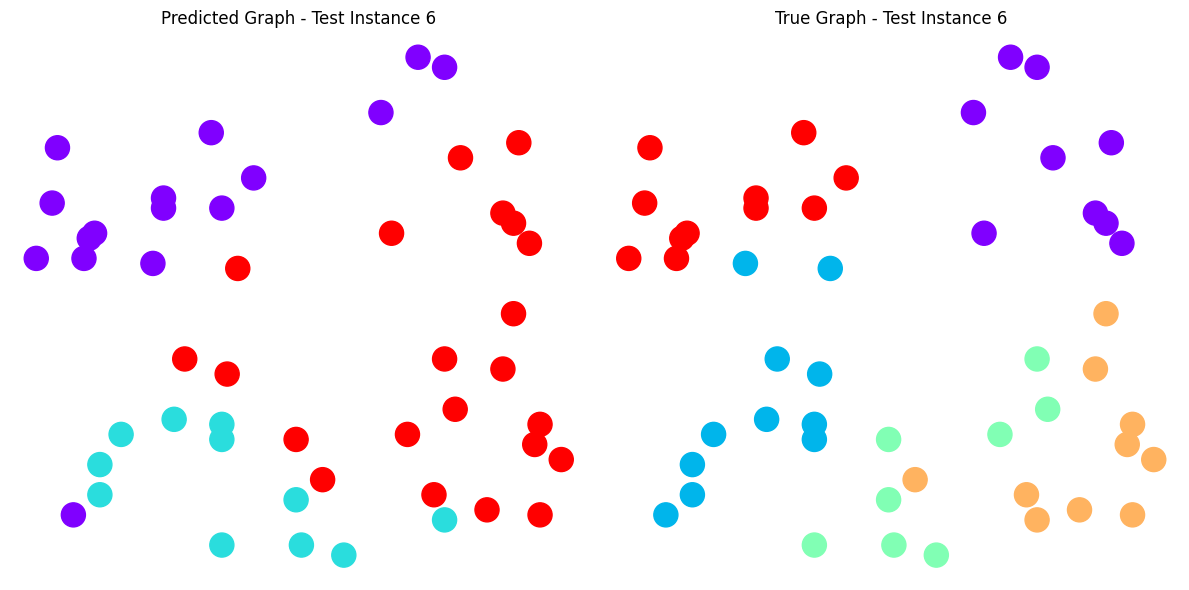

In [ ]:
# Select a test instance to visualize
test_instance_index = 5
test_instance = test_loader.dataset[test_instance_index]

print(test_instance)

# Get the predicted output for the test instance
with torch.no_grad():
    predicted_output = model(test_instance)

# Reshape the predicted output for visualization
predicted_classes = predicted_output.argmax(dim=1)

# Get the corresponding test Data object
test_instance_data = test_data[test_instance_index]

# Extract the features, target, and edge index from the Data object
test_features = test_instance_data.x
test_target = test_instance_data.y
test_edge_index = test_instance_data.edge_index

# Create a NetworkX graph
graph = nx.Graph()
num_nodes = test_features.size(0)
graph.add_nodes_from(range(num_nodes))
# graph.add_edges_from(zip(test_edge_index[0].tolist(), test_edge_index[1].tolist()))

# Get the positions of the nodes from test_instance.x
node_positions = test_features[:, :2].tolist()  # Assuming the first two columns of test_features are the positions

# Plot the graph with node colors representing the predicted classes

# Plot the predicted graph with node colors representing the predicted classes
predicted_node_colors = predicted_classes.tolist()
plt.figure(figsize=(12, 6))
plt.subplot(121)
nx.draw_networkx(graph, pos=dict(enumerate(node_positions)), node_color=predicted_node_colors, cmap='rainbow', with_labels=False)
plt.title(f"Predicted Graph - Test Instance {test_instance_index+1}")
plt.axis('off')

# Plot the true graph with node colors representing the true classes
true_node_colors = test_target.tolist()
plt.subplot(122)
nx.draw_networkx(graph, pos=dict(enumerate(node_positions)), node_color=true_node_colors, cmap='rainbow', with_labels=False)
plt.title(f"True Graph - Test Instance {test_instance_index+1}")
plt.axis('off')

plt.tight_layout()
plt.show()


Test model against CP

In [ ]:
import random

def generate_data_model(grid_size, num_locations, num_vehicles,init_depot):
    """Generates the data for the problem with a grid and randomly placed locations."""
    data = {}
    
    # Generate the grid
    grid = [(x, y) for x in range(grid_size) for y in range(grid_size)]
    
    # Randomly select locations from the grid
    locations = init_depot + random.sample(grid, num_locations-1)
    
    # Calculate distances between locations
    distance_matrix = []
    for i in range(num_locations):
        row = []
        for j in range(num_locations):
            if i == j:
                row.append(0)
            else:
                dist = abs(locations[i][0] - locations[j][0]) + abs(locations[i][1] - locations[j][1])
                row.append(dist)
        distance_matrix.append(row)
    
    data['locations'] = locations
    data['distance_matrix'] = distance_matrix
    data['num_vehicles'] = num_vehicles
    data['depot'] = 0  # Assuming the depot is located at index 0
    
    return data

In [ ]:
from ortools.constraint_solver import routing_enums_pb2
from ortools.constraint_solver import pywrapcp

def initialize(data):
    # Create the routing index manager.
    manager = pywrapcp.RoutingIndexManager(len(data['distance_matrix']),
                                            data['num_vehicles'], data['depot'])

    # Create Routing Model.
    routing = pywrapcp.RoutingModel(manager)


    # Create and register a transit callback.
    def distance_callback(from_index, to_index):
        """Returns the distance between the two nodes."""
        # Convert from routing variable Index to distance matrix NodeIndex.
        from_node = manager.IndexToNode(from_index)
        to_node = manager.IndexToNode(to_index)
        return data['distance_matrix'][from_node][to_node]

    transit_callback_index = routing.RegisterTransitCallback(distance_callback)

    # Define cost of each arc.
    routing.SetArcCostEvaluatorOfAllVehicles(transit_callback_index)

    # Add Distance constraint.
    dimension_name = 'Distance'
    routing.AddDimension(
        transit_callback_index,
        0,  # no slack
        5000,  # vehicle maximum travel distance
        True,  # start cumul to zero
        dimension_name)
    distance_dimension = routing.GetDimensionOrDie(dimension_name)
    distance_dimension.SetGlobalSpanCostCoefficient(100)
    
    return routing,manager

In [ ]:
def convert_to_initial_solution(solution, manager, routing, data):
    initial_routes = []
    for vehicle_id in range(data['num_vehicles']):
        index = routing.Start(vehicle_id)
        route = []
        while not routing.IsEnd(index):
            node_index = manager.IndexToNode(index)
            if node_index != 0:
                route.append(data['locations'][node_index])
            index = solution.Value(routing.NextVar(index))
        initial_routes.append(route)
    return initial_routes

In [ ]:
def print_solution(data, manager, routing, solution):
    """Prints solution on console."""
    print(f'Objective: {solution.ObjectiveValue()}')
    max_route_distance = 0
    for vehicle_id in range(data['num_vehicles']):
        index = routing.Start(vehicle_id)
        plan_output = 'Route for vehicle {}:\n'.format(vehicle_id)
        route_distance = 0
        while not routing.IsEnd(index):
            node_index = manager.IndexToNode(index)
            location_coord = data['locations'][node_index]
            plan_output += ' ({},{}) -> '.format(location_coord[0], location_coord[1])
            previous_index = index
            index = solution.Value(routing.NextVar(index))
            route_distance += routing.GetArcCostForVehicle(previous_index, index, vehicle_id)
        plan_output += 'Distance of the route: {}m\n'.format(route_distance)
        print(plan_output)
        max_route_distance = max(route_distance, max_route_distance)
    print('Maximum of the route distances: {}m'.format(max_route_distance))


In [ ]:
# Instantiate the data problem.
grid_size=100
random_locations=50
num_vehicles=5
init_depot = [(50,50)]

cp_data = generate_data_model(grid_size,random_locations,num_vehicles,init_depot)

Run CP without any hint

In [ ]:
routing,manager = initialize(cp_data)

# Setting first solution heuristic.
search_parameters = pywrapcp.DefaultRoutingSearchParameters()
search_parameters.first_solution_strategy = routing_enums_pb2.FirstSolutionStrategy.PATH_CHEAPEST_ARC
search_parameters.local_search_metaheuristic = (
    routing_enums_pb2.LocalSearchMetaheuristic.GUIDED_LOCAL_SEARCH)
search_parameters.time_limit.seconds = 10  # Set a time limit for the solver.

# Solve the problem.
solution = routing.SolveWithParameters(search_parameters)

In [ ]:
if solution:
    print_solution(cp_data, manager, routing, solution)
else:
    print('No solution found!')

Objective: 22640
Route for vehicle 0:
 (50,50) ->  (51,16) ->  (62,14) ->  (59,4) ->  (44,14) ->  (15,18) ->  (6,18) ->  (0,33) ->  (36,43) -> Distance of the route: 216m

Route for vehicle 1:
 (50,50) ->  (40,38) ->  (37,38) ->  (35,32) ->  (31,23) ->  (28,24) ->  (27,19) ->  (25,17) ->  (22,9) ->  (13,44) ->  (18,65) ->  (19,74) ->  (24,74) ->  (28,73) ->  (34,46) -> Distance of the route: 214m

Route for vehicle 2:
 (50,50) ->  (86,68) ->  (95,69) ->  (89,85) ->  (80,95) ->  (71,91) ->  (45,94) -> Distance of the route: 196m

Route for vehicle 3:
 (50,50) ->  (64,22) ->  (70,28) ->  (76,30) ->  (81,19) ->  (79,13) ->  (73,6) ->  (90,11) ->  (91,28) ->  (91,33) ->  (85,35) ->  (89,45) ->  (80,44) -> Distance of the route: 212m

Route for vehicle 4:
 (50,50) ->  (16,56) ->  (2,62) ->  (12,68) ->  (10,78) ->  (7,94) ->  (22,98) ->  (28,89) ->  (37,86) ->  (49,82) -> Distance of the route: 202m

Maximum of the route distances: 216m


Run CP with GNN hint

In [ ]:
def convert_to_initial_solution(solution, manager, routing, data):
    initial_routes = []
    for vehicle_id in range(data['num_vehicles']):
        index = routing.Start(vehicle_id)
        route = []
        while not routing.IsEnd(index):
            node_index = manager.IndexToNode(index)
            if node_index != 0:
                route.append(data['locations'][node_index])
            index = solution.Value(routing.NextVar(index))
        initial_routes.append(route)
    
    solution = []
    for i,vehicle_route in enumerate(initial_routes):
        for coord in vehicle_route:
            solution.append([coord[0], coord[1], i])
    return solution

In [ ]:
convert_solution = convert_to_initial_solution(solution, manager, routing,cp_data)
print(convert_solution)

locations = []
targets = []
for location in convert_solution:
    locations.append([location[0],location[1]])
    targets.append(location[2])

print(locations)
print(targets)

[[51, 16, 0], [62, 14, 0], [59, 4, 0], [44, 14, 0], [15, 18, 0], [6, 18, 0], [0, 33, 0], [36, 43, 0], [40, 38, 1], [37, 38, 1], [35, 32, 1], [31, 23, 1], [28, 24, 1], [27, 19, 1], [25, 17, 1], [22, 9, 1], [13, 44, 1], [18, 65, 1], [19, 74, 1], [24, 74, 1], [28, 73, 1], [34, 46, 1], [86, 68, 2], [95, 69, 2], [89, 85, 2], [80, 95, 2], [71, 91, 2], [45, 94, 2], [64, 22, 3], [70, 28, 3], [76, 30, 3], [81, 19, 3], [79, 13, 3], [73, 6, 3], [90, 11, 3], [91, 28, 3], [91, 33, 3], [85, 35, 3], [89, 45, 3], [80, 44, 3], [16, 56, 4], [2, 62, 4], [12, 68, 4], [10, 78, 4], [7, 94, 4], [22, 98, 4], [28, 89, 4], [37, 86, 4], [49, 82, 4]]
[[51, 16], [62, 14], [59, 4], [44, 14], [15, 18], [6, 18], [0, 33], [36, 43], [40, 38], [37, 38], [35, 32], [31, 23], [28, 24], [27, 19], [25, 17], [22, 9], [13, 44], [18, 65], [19, 74], [24, 74], [28, 73], [34, 46], [86, 68], [95, 69], [89, 85], [80, 95], [71, 91], [45, 94], [64, 22], [70, 28], [76, 30], [81, 19], [79, 13], [73, 6], [90, 11], [91, 28], [91, 33], [85

In [ ]:
# get GNN hint
# convert the data to a torch_geometric Data object with the edge_index as the adjacency matrix
# Preprocess the data
instance_tensor = torch.tensor(locations, dtype=torch.float)
edge_index = kneighbors_graph(instance_tensor, n_neighbors=k, mode='connectivity', include_self=False).tocoo()

torch_data = Data(x=instance_tensor, edge_index=torch.tensor([edge_index.row, edge_index.col], dtype=torch.long), y=torch.tensor(targets, dtype=torch.long))
print(torch_data)

Data(x=[49, 2], edge_index=[2, 1470], y=[49])


In [ ]:
# Get the predicted output for the test instance
with torch.no_grad():
    predicted_output = model(torch_data)
accuracy = (predicted_output.argmax(dim=1) == torch_data.y).sum().item() / len(torch_data.y)
print('accuracy:',accuracy)

accuracy: 0.14285714285714285


In [ ]:
# convert the predicted output to a solution
initial_solution = []
for i,coord in enumerate(instance_tensor):
    initial_solution.append([coord[0].item(), coord[1].item(), predicted_output[i].argmax().item()])
print(initial_solution)

[[51.0, 16.0, 1], [62.0, 14.0, 1], [59.0, 4.0, 4], [44.0, 14.0, 1], [15.0, 18.0, 1], [6.0, 18.0, 1], [0.0, 33.0, 0], [36.0, 43.0, 0], [40.0, 38.0, 0], [37.0, 38.0, 0], [35.0, 32.0, 0], [31.0, 23.0, 1], [28.0, 24.0, 1], [27.0, 19.0, 1], [25.0, 17.0, 1], [22.0, 9.0, 1], [13.0, 44.0, 0], [18.0, 65.0, 0], [19.0, 74.0, 0], [24.0, 74.0, 0], [28.0, 73.0, 0], [34.0, 46.0, 0], [86.0, 68.0, 1], [95.0, 69.0, 1], [89.0, 85.0, 1], [80.0, 95.0, 0], [71.0, 91.0, 0], [45.0, 94.0, 0], [64.0, 22.0, 1], [70.0, 28.0, 1], [76.0, 30.0, 1], [81.0, 19.0, 4], [79.0, 13.0, 4], [73.0, 6.0, 4], [90.0, 11.0, 4], [91.0, 28.0, 4], [91.0, 33.0, 4], [85.0, 35.0, 1], [89.0, 45.0, 1], [80.0, 44.0, 1], [16.0, 56.0, 0], [2.0, 62.0, 0], [12.0, 68.0, 0], [10.0, 78.0, 0], [7.0, 94.0, 0], [22.0, 98.0, 0], [28.0, 89.0, 0], [37.0, 86.0, 0], [49.0, 82.0, 0]]


In [ ]:
routing,manager = initialize(cp_data)

# Close model with the custom search parameters.
search_parameters = pywrapcp.DefaultRoutingSearchParameters()
search_parameters.first_solution_strategy = (
    routing_enums_pb2.FirstSolutionStrategy.PATH_CHEAPEST_ARC)
search_parameters.local_search_metaheuristic = (
    routing_enums_pb2.LocalSearchMetaheuristic.GUIDED_LOCAL_SEARCH)
search_parameters.time_limit.FromSeconds(9)
# When an initial solution is given for search, the model will be closed with the default
# search parameters unless it is explicitly closed with the custom search parameters.
routing.CloseModelWithParameters(search_parameters)

# Get initial solution from routes after closing the model.
cp_initial_solution = routing.ReadAssignmentFromRoutes(initial_solution, True)

# Solve the problem.
solution = routing.SolveFromAssignmentWithParameters(
    cp_initial_solution, search_parameters)

# Print solution on console.
if solution:
    print('Solution after search:')
    print_solution(cp_data, manager, routing, solution)

Solution after search:
Objective: 22640
Route for vehicle 0:
 (50,50) ->  (51,16) ->  (62,14) ->  (59,4) ->  (44,14) ->  (15,18) ->  (6,18) ->  (0,33) ->  (36,43) -> Distance of the route: 216m

Route for vehicle 1:
 (50,50) ->  (40,38) ->  (37,38) ->  (35,32) ->  (31,23) ->  (28,24) ->  (27,19) ->  (25,17) ->  (22,9) ->  (13,44) ->  (18,65) ->  (19,74) ->  (24,74) ->  (28,73) ->  (34,46) -> Distance of the route: 214m

Route for vehicle 2:
 (50,50) ->  (86,68) ->  (95,69) ->  (89,85) ->  (80,95) ->  (71,91) ->  (45,94) -> Distance of the route: 196m

Route for vehicle 3:
 (50,50) ->  (64,22) ->  (70,28) ->  (76,30) ->  (81,19) ->  (79,13) ->  (73,6) ->  (90,11) ->  (91,28) ->  (91,33) ->  (85,35) ->  (89,45) ->  (80,44) -> Distance of the route: 212m

Route for vehicle 4:
 (50,50) ->  (16,56) ->  (2,62) ->  (12,68) ->  (10,78) ->  (7,94) ->  (22,98) ->  (28,89) ->  (37,86) ->  (49,82) -> Distance of the route: 202m

Maximum of the route distances: 216m
